# Import Libraries

In [1]:
# For Data

import json
import pandas as pd
import numpy as np

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For Processing
import re
import nltk

# For Bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

# For Explainer
from lime import lime_text

# For Word Embedding
import gensim
import gensim.downloader as gensim_api

# For Deep Learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# For BERT language Model
import transformers

# Data

The dataset is contained into json file, so I will first read it into a list of dictionaries with json and then transform it into a pandas Dataframe

In [2]:
list_dics = []
with open('News_Category_Dataset_v2.json', mode = 'r', errors = 'ignore') as json_file:
    for dic in json_file:
        list_dics.append(json.loads(dic))
        
# Print the first one
list_dics[0]


{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

The original dataset contains over 30 categories, but for the purpose lets use 3

In [3]:
# DataFrame
dtf = pd.DataFrame(list_dics)

# Filter categories
dtf = dtf[dtf['category'].isin(['ENTERTAINMENT', 'POLITICS', 'TECH'])][['category', 'headline']]
dtf

,category,headline
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...
...,...,...
200844,TECH,Google+ Now Open for Teens With Some Safeguards
200845,TECH,Web Wars
200846,TECH,"First White House Chief Technology Officer, An..."
200847,TECH,Watch The Top 9 YouTube Videos Of The Week


In [4]:
# Rename columns
dtf = dtf.rename(columns = {"category" : 'y', 'headline': 'text'})

 univariate distribution of the target by showing labels frequency with a bar plot

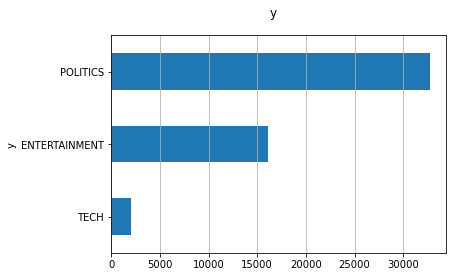

In [5]:
fig, ax  = plt.subplots()
fig.suptitle('y', fontsize = 12)
dtf['y'].reset_index().groupby('y').count().sort_values(by = 'index').plot(kind = 'barh', legend = False, ax = ax).grid(axis = 'x')

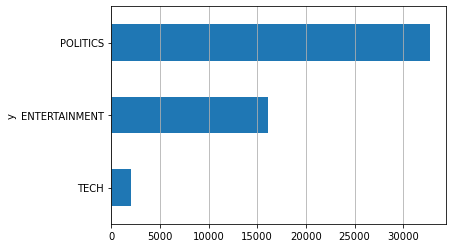

In [16]:
dtf['y'].reset_index().groupby('y').count().sort_values(by = 'index').plot(kind = 'barh', legend = False).grid(axis = 'x')

In [19]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''

def utils_preprocess_text(text, flg_stemm = False, flg_lemm = True, lst_stopwords = None):
    # Clean (convert to lowercase and remove punctuations and characters and then strio)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # Tokenize
    lst_text = text.split()
    
    # Remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
        
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.proter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
        
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
        
    # Back to string from list
    text = ' '.join(lst_text)
    return text

In [20]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Now I shall apply the function I wrote on the whole dataset and store the result in a new column named “text_clean” so that you can choose to work with the raw corpus or the preprocessed text.

In [21]:
dtf['text_clean'] = dtf['text'].apply(lambda x: utils_preprocess_text(x, flg_stemm = False, flg_lemm = True, lst_stopwords = lst_stopwords))
dtf.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


In [22]:
# Split Dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size = 0.3)

# Target
y_train = dtf_train['y'].values
y_test = dtf_test['y'].values

# Bag of Words

In [23]:
# Tf-Idf (Advanced Variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features = 10000, ngram_range = (1,2))

Now I will use the vectorizer on the preprocessed corpus of the train set to extract a vocabulary and create the feature matrix.

In [24]:
corpus = dtf_train['text_clean']

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [26]:
dic_vocabulary

{'rihanna': 7407,
 'best': 889,
 'response': 7304,
 'asked': 634,
 'attending': 667,
 'royal': 7523,
 'wedding': 9691,
 'best response': 900,
 'devos': 2470,
 'dont': 2630,
 'know': 4913,
 'whether': 9745,
 'sexual': 7936,
 'assault': 640,
 'false': 3130,
 'accusation': 203,
 'dont know': 2637,
 'sexual assault': 7938,
 'celebrity': 1467,
 'dad': 2178,
 'daughter': 2231,
 'make': 5348,
 'half': 3892,
 'democrat': 2371,
 'want': 9597,
 'joe': 4663,
 'biden': 928,
 '2016': 58,
 'race': 6976,
 'democrat want': 2385,
 'joe biden': 4665,
 '2016 race': 65,
 'journalism': 4727,
 'challenge': 1502,
 'state': 8332,
 'emergency': 2878,
 'state emergency': 8337,
 'rock': 7460,
 'star': 8318,
 'two': 9329,
 'hope': 4149,
 'save': 7669,
 'america': 404,
 'trump': 9035,
 'making': 5370,
 'first': 3308,
 'sport': 8276,
 'car': 1378,
 'remember': 7183,
 'wwii': 9919,
 'wrong': 9915,
 'answer': 496,
 'congress': 1884,
 'still': 8392,
 'good': 3689,
 'delivering': 2357,
 'washington': 9646,
 'insider': 

In [29]:
X_train.shape

(35615, 10000)

In [33]:
dic_vocabulary['new york']

6024

In order to drop some columns and reduce the matrix dimensionality, we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:
- treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
- perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
- keep only the features with a certain p-value from the Chi-Square test.

In [35]:
y = dtf_train['y']
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y == cat)
    dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score": 1 - p, "y": cat}))

NameError: name 'feature_selection' is not defined

In [36]:
np.unique(dtf_train['y'])

array(['ENTERTAINMENT', 'POLITICS', 'TECH'], dtype=object)